In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
#Creating decision tree model with combined + cleaned dataset: train_merge_all.csv, test_merge_all.csv
train = pd.read_csv('train_merge_all.csv')
test = pd.read_csv('test_merge_all.csv')

train = train.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1)
test = test.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1)

In [3]:
#check train + test set variable sets: these do not include target Y = WnvPresent (0/1)
print(train.shape, test.shape)
print('\n')
print(train.columns, '\n\n', test.columns)

(10506, 28) (116293, 28)


Index(['Date', 'Species', 'Trap', 'Longitude', 'Latitude', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'DaysFromSpray', 'LogDays', 'SprayEffect'],
      dtype='object') 

 Index(['Date', 'Species', 'Trap', 'Longitude', 'Latitude', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'DaysFromSpray', 'LogDays', 'SprayEffect'],
      dtype='object')


In [4]:
#replaced
#turn text features (col CodeSum from weather data) into categories
#train = pd.get_dummies(train)
#train.head()

#test = pd.get_dummies(test)
#test.head()

In [5]:
#Set X (variable) and y (target) datasets for training data
X = train

y = pd.read_csv('target.csv')
y.head()

print(X.shape, y.shape)

(10506, 28) (10506, 1)


In [6]:
#Set baseline accuracy
print(y['WnvPresent'].value_counts())
baseline = y['WnvPresent'].value_counts() / len(y)
print(baseline)

0    9955
1     551
Name: WnvPresent, dtype: int64
0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64


In [7]:
#function to prepare dataset for modeling

def process_features(df, drop_cols):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = pd.to_numeric(df['Date'])
    df.drop(columns = drop_cols, inplace = True)
    df = pd.get_dummies(df, columns = ['Species'])
    
    # create dummies for weather codes
    
    # replace str object with list
    df['CodeSum'] = df['CodeSum'].map(lambda x: re.findall(r'([A-Z\+\-]+)', x))
    
    # find all unique codes in the dataframe
    codes = []
    for value in df['CodeSum'].values:
        codes.extend(value)  
    codes = set(codes)
    
    # add dummy flags for each unique code
    for code in codes:
        df[code] = df['CodeSum'].map(lambda x: 1 if code in x else 0)
        
    df.drop(columns='CodeSum', inplace = True)
        
    return df

In [8]:
#train
X = process_features(X, drop_cols = ['Date', 'Trap'])

#test
test = process_features(test, drop_cols = ['Date', 'Trap'])

In [12]:
test.head()
train.head()

,Species,Longitude,Latitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,DaysFromSpray,LogDays,SprayEffect
0,CULEX PIPIENS/RESTUANS,-87.800991,41.954690,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
1,CULEX RESTUANS,-87.800991,41.954690,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
2,CULEX RESTUANS,-87.769279,41.994991,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
3,CULEX PIPIENS/RESTUANS,-87.824812,41.974089,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
4,CULEX RESTUANS,-87.824812,41.974089,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0


In [13]:
#train-test-split training set: 75/25 split, stratify y to preseve distro
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7879, 46) (7879, 1)
(2627, 46) (2627, 1)


In [14]:
#standard scale
ss = StandardScaler()
ss.fit_transform(X_train)
ss.fit(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
#balance classes in X_train (training set of training set)

import numpy as np
C0_ratio = 2/3
C1_ratio = 1 - C0_ratio
Total = len(y_train['WnvPresent'])

#from class 0 observations, random sample 5253
    #rows from X_train that are class 0
X_train_C0_rows = [i for i in X_train[y_train['WnvPresent'] == 0].index]
X_train_C0_undersample = np.random.choice(X_train_C0_rows, int(round(C0_ratio*Total, 0)), replace = False)
X_train_C0_undersample = list(X_train_C0_undersample)

#from class 1 observations, random sample 2626
    #rows from X_train that are class 1
X_train_C1_rows = [i for i in X_train[y_train['WnvPresent'] == 1].index]
X_train_C1_oversample = np.random.choice(X_train_C1_rows, int(round(C1_ratio*Total, 0)), replace = True)
X_train_C1_oversample = list(X_train_C1_oversample)

#reset X_train and y_train
X_train_balanced = X_train_C0_undersample + X_train_C1_oversample
X_train = X_train.loc[X_train_balanced, :]
y_train = y_train.loc[X_train_balanced, :]

In [16]:
#checker
y_train['WnvPresent'].value_counts()
X_train.head()

,Longitude,Latitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,MIFG,BCFG,VCFG,TSRA,TS,BR,FG+,RA,FG,HZ
1909,-87.686763,41.843811,85.4,69.2,77.6,4.3,66.4,70.3,0.0,12.6,...,0,0,0,1,1,1,0,1,0,1
6340,-87.666901,41.868077,77.2,61.9,69.8,-1.7,56.1,61.7,0.1,4.9,...,0,0,0,0,0,1,0,1,0,1
3995,-87.763416,41.801498,70.8,48.7,59.9,-5.1,44.9,52.0,5.3,0.2,...,0,0,0,1,0,1,0,1,0,0
434,-87.666455,41.921600,80.5,62.7,71.9,-1.6,55.4,62.0,0.0,6.9,...,0,0,0,1,0,1,0,1,0,0
7632,-87.807277,42.009876,81.0,62.6,72.1,1.7,58.6,63.8,0.0,7.1,...,0,0,0,0,0,0,0,1,0,0


In [50]:
#instantiate, fit + score Decision Tree classifier
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
print('train:', 'acc:', tree.score(X_train, y_train['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_train['WnvPresent'], tree.predict(X_train)))
print('test:', 'acc:', tree.score(X_test, y_test['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_test['WnvPresent'], tree.predict(X_test)))    #biased


train: acc: 0.9697931209544358 roc_auc_score:  0.9715378612939272
test: acc: 0.8778073848496384 roc_auc_score:  0.6138196470266274


In [51]:
#bagging classifier with DecisionTreeClassifier
bag = BaggingClassifier(random_state = 42, base_estimator = DecisionTreeClassifier(), n_estimators = 100, verbose = 0)
bag.fit(X_train, y_train)
print('train:', bag.score(X_train, y_train['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_train['WnvPresent'], bag.predict(X_train)))
print('test:', bag.score(X_test, y_test['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_test['WnvPresent'], bag.predict(X_test)))    #better performance + less bias than DT

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train: 0.9697931209544358 roc_auc_score:  0.9717283011963279
test: 0.8995051389417587 roc_auc_score:  0.6355369422560716


In [20]:
#bagging classifier with DecisionTreeClassifier tuning hyperparameters with GridSearchCV
    #Reference: 6.02-lesson-bagging-rfs
    #iter1
bag = BaggingClassifier(random_state=42, base_estimator = DecisionTreeClassifier())
bag_params = {
    'base_estimator__max_depth': range(2, 4),    #iter1: range(1, 10)
    'base_estimator__min_samples_split': range(2, 5),    #iter1: range(2, 10)
    'n_estimators': [10, 20, 50, 75, 100]    #iter1: [1, 2, 5, 7, 9, 10]
}


gs = GridSearchCV(bag, param_grid=bag_params)
gs.fit(X_train, y_train)

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ..., n_estimators=10, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator__max_depth': range(2, 4), 'base_estimator__min_samples_split': range(2, 5), 'n_estimators': [10, 20, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
#iter2
bag = BaggingClassifier(random_state=42, base_estimator = DecisionTreeClassifier())
bag_params = {
    'base_estimator__max_depth': range(1, 10),
    'base_estimator__min_samples_split': range(2, 10),
    'n_estimators': [1, 2, 5, 7, 9, 10]
}


gs = GridSearchCV(bag, param_grid=bag_params)
gs.fit(X_train, y_train)

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ..., n_estimators=10, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator__max_depth': range(1, 10), 'base_estimator__min_samples_split': range(2, 10), 'n_estimators': [1, 2, 5, 7, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
#iter3
#bag = BaggingClassifier(random_state=42, base_estimator = DecisionTreeClassifier())
#bag_params = {
#    'base_estimator__max_depth': range(1, 10),
#    'base_estimator__min_samples_split': range(2, 10),
#    'n_estimators': [40, 50, 75, 100, 125, 200]
#}

#gs = GridSearchCV(bag, param_grid=bag_params)
#gs.fit(X_train, y_train)

In [53]:
print('train:', gs.best_score_)
print('train:', gs.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [54]:
#try bagging classifier with best_params from tuning
best = BaggingClassifier(random_state = 42, 
                         base_estimator = DecisionTreeClassifier(
                             max_depth = gs.best_params_['base_estimator__max_depth'], 
                             min_samples_split = gs.best_params_['base_estimator__min_samples_split']), 
                         n_estimators = gs.best_params_['n_estimators'])

best.fit(X_train, y_train)
print(gs.best_params_)
print('train:', 'acc:', best.score(X_train, y_train['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_train['WnvPresent'], best.predict(X_train)))
print('test:', 'acc:', best.score(X_test, y_test['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_test['WnvPresent'], best.predict(X_test)))    


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [27]:
summary = {
    'iter1':
    
    """
    {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 2, 'n_estimators': 50}
train: acc: 0.7445107247112578 roc_auc_score:  0.7373611191457854
test: acc: 0.7476208602969167 roc_auc_score:  0.7128102782678568
    """,
    
    'iter2':
    
    """
    {'base_estimator__max_depth': 9, 'base_estimator__min_samples_split': 2, 'n_estimators': 9}
train: acc: 0.8960527985784998 roc_auc_score:  0.904047975196852
test: acc: 0.8446897601827179 roc_auc_score:  0.6887449706243705
    """,
    
    'iter3':
    
    """
    
    """
}

summary
#iter1: 0.74 / 0.71
    #slight bias, accuracy drop
#iter2: 0.90 / 0.69
    #more bias, better accuracy
#iter3: 

{'iter1': "\n    {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 2, 'n_estimators': 50}\ntrain: acc: 0.7445107247112578 roc_auc_score:  0.7373611191457854\ntest: acc: 0.7476208602969167 roc_auc_score:  0.7128102782678568\n    ",
 'iter2': "\n    {'base_estimator__max_depth': 9, 'base_estimator__min_samples_split': 2, 'n_estimators': 9}\ntrain: acc: 0.8960527985784998 roc_auc_score:  0.904047975196852\ntest: acc: 0.8446897601827179 roc_auc_score:  0.6887449706243705\n    "}

In [55]:
#Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('train:', 'acc:', rf.score(X_train, y_train['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_train['WnvPresent'], rf.predict(X_train)))
print('test:', 'acc:', rf.score(X_test, y_test['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_test['WnvPresent'], rf.predict(X_test)))    #biased, performance on par with bagged DT


train: acc: 0.9691585226551593 roc_auc_score: 0.970776282917577
test: acc: 0.8937952036543586 roc_auc_score: 0.6359459884360753


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [56]:
#ExtraTrees classifier
et = ExtraTreesClassifier()
et.fit(X_train, y_train)
print('train:', 'acc:', et.score(X_train, y_train['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_train['WnvPresent'], et.predict(X_train)))
print('test:', 'acc:', et.score(X_test, y_test['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_test['WnvPresent'], et.predict(X_test)))    #biased, performance on par with bagged DT


train: acc: 0.9697931209544358 roc_auc_score: 0.9715378612939272
test: acc: 0.9029311001141987 roc_auc_score: 0.6168110701579704


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [37]:
summary

{'iter1': "\n    {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 2, 'n_estimators': 50}\ntrain: acc: 0.7445107247112578 roc_auc_score:  0.7373611191457854\ntest: acc: 0.7476208602969167 roc_auc_score:  0.7128102782678568\n    ",
 'iter2': "\n    {'base_estimator__max_depth': 9, 'base_estimator__min_samples_split': 2, 'n_estimators': 9}\ntrain: acc: 0.8960527985784998 roc_auc_score:  0.904047975196852\ntest: acc: 0.8446897601827179 roc_auc_score:  0.6887449706243705\n    "}

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

best = BaggingClassifier(random_state = 42, 
                         base_estimator = DecisionTreeClassifier(
                             max_depth = 3, 
                             min_samples_split = 2), 
                         n_estimators = 50)

best.fit(X_train, y_train['WnvPresent'])

print('Train Accuracy:', best.score(X_train, y_train['WnvPresent']))
print('Test Accuracy:', best.score(X_test, y_test['WnvPresent']))

y_hat_prob_train = best.predict_proba(X_train)
y_hat_prob_train = [x[1] for x in y_hat_prob_train]
print('ROC AUC:', roc_auc_score(y_train['WnvPresent'], y_hat_prob_train))

y_hat_prob = best.predict_proba(X_test)
y_hat_prob1 = [x[1] for x in y_hat_prob]
print('ROC AUC:', roc_auc_score(y_test['WnvPresent'], y_hat_prob1))

Train Accuracy: 0.7445107247112578
Test Accuracy: 0.7476208602969167
ROC AUC: 0.8250009895335622
ROC AUC: 0.7880849651510122


Confusion matrix:


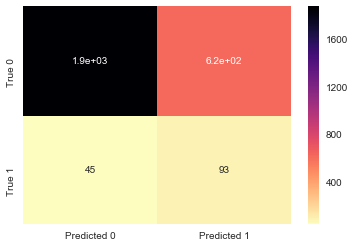

In [71]:
y_hat = best.predict(X_test)

print('Confusion matrix:')
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, cmap='magma_r', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1']);

In [61]:
#comparing against LogReg model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
print('train:', 'acc:', lr.score(X_train, y_train['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_train['WnvPresent'], lr.predict(X_train)))
print('test:', 'acc:', lr.score(X_test, y_test['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_test['WnvPresent'], lr.predict(X_test)))    #overfit


train: acc: 0.7522528239624318 roc_auc_score: 0.7056506643503607
test: acc: 0.8382185001903312 roc_auc_score: 0.6853299445094648


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
#reset baseline
baseline = y_train['WnvPresent'].value_counts()[1] / len(y_train['WnvPresent'])
baseline

0.33329102678004824

In [100]:
#drop Type: unspecified mosquito species + additional weather codesum fields that appear in train but not test set
#test = test.drop(['Species_UNSPECIFIED CULEX'], axis = 1)
X_train, test = X_train.align(test, join='outer', axis=1, fill_value=0)
print(X_train.shape, X_test.shape, test.shape)

(7879, 48) (2627, 47) (116293, 48)


In [95]:
#predict target WnvPresent in test_merge_all.csv
y_pred = best.predict(test)
y_pred[0:100]


In [96]:
#input target values to sample submission format + save to_csv

#test['WnvPresent'].value_counts()
test['WnvPresent'] = y_pred
test = test.loc[:, ['WnvPresent']]
test.index += 1    #reset index to start at 1
test.index.names = ['Id']

test.to_csv('sample1hc.csv')